In [1]:
from __future__ import division
import os
import numpy as np
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import data_loader
from imp import reload
#reload(data_loader)


from data_loader import DataLoader
import module 
reload(module)
from module import *
from utils import *
from option import *
#from keras import backend as K
from keras.callbacks import TensorBoard
#import tensorflow as tf 


import sys
sys.path.insert(0, '../../segmentation_results_infrared_cyclegan_generated/lib/')
sys.path.insert(0, '../../segmentation_results_infrared_cyclegan_generated/')
import numpy as np
from matplotlib import pyplot as plt
#Keras
from keras.models import model_from_json
from keras.models import Model
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
import sys
sys.path.insert(0, './lib/')
# help_functions.py
from help_functions import *
# extract_patches.py
from imp import reload
import extract_patches
reload(extract_patches)
from extract_patches import recompone
from extract_patches import recompone_overlap
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from pre_processing import my_PreProc

from __future__ import division
from keras.layers import Conv2D,UpSampling2D
from keras.losses import binary_crossentropy
from keras.activations import sigmoid
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.normalization import InstanceNormalization
from keras.layers import Input, Lambda, add
from keras.models import Model
import keras.backend as k
import tensorflow as tf
from keras.initializers import RandomNormal

from keras.engine.topology import Layer
import keras.backend as k



import os
import numpy as np
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import data_loader
#from imp import reload
#reload(data_loader)

from data_loader import DataLoader

import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, Convolution2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class cyclegan(object):
    def __init__(self, opt):
        self.discriminator = capsule_discriminator
        self.generator = generator_resnet
        self.criterionGAN = mae_criterion
        self.opt = opt
        self.img_shape = (self.opt.data_pix_size, self.opt.data_pix_size, self.opt.in_dim)
        self.build_model()
        self.pool = ImagePool(self.opt.max_size)

    def build_model(self):
        self.lambda_id = self.opt.lambda_id * self.opt.lambda_cycle
        self.d_A = capsule_discriminator(self.opt)
        self.d_B = capsule_discriminator(self.opt)
        self.optimizer = Adam(self.opt.lr, self.opt.beta1)
        self.d_A.compile(loss='binary_crossentropy',
                         optimizer=self.optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='binary_crossentropy',
                         optimizer=self.optimizer,
                         metrics=['accuracy'])
        self.g_AB = generator_unet()
        self.g_BA = generator_unet()
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)
        #style transfer
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        #reconstructure
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        #identity
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        #to train generator
        self.d_A.trainable = False
        self.d_B.trainable = False

        #dicriminator determine validity
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)
        

        # Combined model trains generators to fool discrgit/model.py:67iminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])


        self.combined.compile(loss=['mean_squared_error', 'mean_squared_error',
                                    'mean_squared_error', 'mean_squared_error',
                                    'mean_squared_error', 'mean_squared_error'],
                              loss_weights=[1, 1,
                                            self.opt.lambda_cycle, self.opt.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=self.optimizer)

        #callback.set_model(self.combined)
        #self.combined.load_weights('model.h5')

    def train(self):
        start_time = datetime.datetime.now()
        # Calculate output shape of D (PatchGAN)
        #patch = int(self.opt.d_patch_size)    ###### change it
        #self.disc_patch = (patch, patch, 1)   ###### change it

        # Adversarial loss ground truths
        #valid = np.ones((self.opt.batch_size,) + self.disc_patch)
        #fake = np.zeros((self.opt.batch_size,) + self.disc_patch)
        
        ######### for capsule ############
        valid = np.ones((self.opt.batch_size))
        fake = np.zeros((self.opt.batch_size,))
        
        
        self.data_loader = DataLoader(dataset_name=self.opt.dataset_name,
                                      img_res=(self.opt.data_pix_size, self.opt.data_pix_size))
        
        
        for epoch in range(25):
                for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(self.opt.batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                    fake_B = self.g_AB.predict_on_batch(imgs_A)
                    fake_A = self.g_BA.predict_on_batch(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                    dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                    dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                    dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                    dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                    d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                    g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                    elapsed_time = datetime.datetime.now() - start_time
                    #train_names = ['train_loss', 'train_mae']

                # Plot the progress
                    print (g_loss)
                    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, self.opt.epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))
                    #write_log(callback, train_names, g_loss, batch_i)
                    
                    

                # If at save interval => save generated image samples
                    if batch_i % self.opt.sample_iter == 0:
                        self.sample_images(epoch, batch_i)

        self.combined.save('model_unet_capsule.json')
        # serialize weights to HDF5
        self.combined.save_weights("weights_unet_capsule_patches.h5")
        #print("Saved model to disk")




    def sample_images(self,epoch, batch_i):
        os.makedirs('images/%s' % self.opt.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.opt.dataset_name, epoch, batch_i))
        
        plt.close()


In [3]:
p = BaseOptions()
opt = p.args
gan = cyclegan(opt)
#gan.train()

In [201]:
#gan.combined.load_weights('weights_unet_capsule_patches.h5')
gan.combined.load_weights('weights_unet_capsule_flu_0.h5')

In [254]:
import scipy
import cv2
img = scipy.misc.imread('../../StarGAN-master/StarGAN-master/data/retina/train_whole/flu/174_XC_Flu_20040119_L_001.png', mode='RGB').astype(np.float)
#img = a.pixel_array.astype(np.float)
img = scipy.misc.imresize(img, (256, 256))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = img/127.5 - 1.
img=img[np.newaxis, :, :, :]
gen_imgs = 0.5 * img + 0.5

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [255]:
p1=gan.combined.get_layer('model_3').predict(img)

In [256]:
p1=0.5 * p1 + 0.5

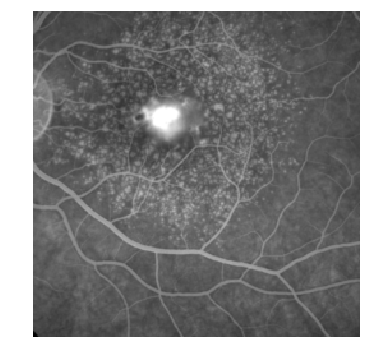

In [257]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(gen_imgs[0])
plt.axis('off')
plt.show()

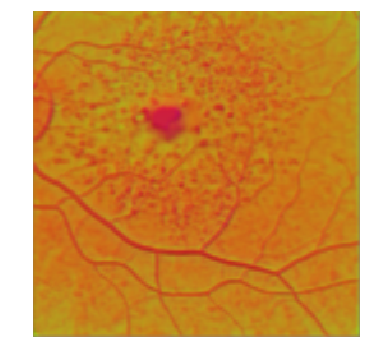

In [258]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(p1[0])
plt.axis('off')
plt.show()

In [268]:
p1 = gen_imgs

In [269]:
test_imgs_orig = np.transpose(p1,(0,3,1,2))
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]
patch_height = 48
patch_width = 48
stride_height = 5
stride_width = 5
assert (stride_height < patch_height and stride_width < patch_width)
Imgs_to_test = 1
N_visual = 1

In [270]:
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_masks_test = None
patches_imgs_test, new_height, new_width = get_data_testing_overlap(
        tst_imgs_original = test_imgs_orig,  
        Imgs_to_test = 1,
        patch_height = patch_height,
        patch_width = patch_width,
        stride_height = stride_height,
        stride_width = stride_width
    )



the side H is not compatible with the selected stride of 5
img_h 256, patch_h 48, stride_h 5
(img_h - patch_h) MOD stride_h: 3
So the H dim will be padded with additional 2 pixels
the side W is not compatible with the selected stride of 5
img_w 256, patch_w 48, stride_w 5
(img_w - patch_w) MOD stride_w: 3
So the W dim will be padded with additional 2 pixels
new full images shape: 
(1, 1, 258, 258)

test images shape:
(1, 1, 258, 258)
test images range (min-max): 0.0 - 1.0
Number of patches on h : 43
Number of patches on w : 43
number of patches per image: 1849, totally for this dataset: 1849

test PATCHES images shape:
(1849, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0


In [271]:
def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [272]:
model = get_unet(1,48, 48)

In [273]:
model.load_weights('../../segmentation_results_infrared_cyclegan_generated/best_model.h5')

In [274]:
predictions = model.predict(patches_imgs_test, batch_size=32, verbose=1)

1849/1849 [==============================] - 1s 460us/step


In [275]:
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")

In [276]:
pred_imgs = None
orig_imgs = None
gtruth_masks = None
pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    #gtruth_masks = masks_test  #ground truth masks

orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]


N_patches_h: 43
N_patches_w: 43
N_patches_img: 1849
According to the dimension inserted, there are 1 full images (of 258x258 each)
(1, 1, 258, 258)


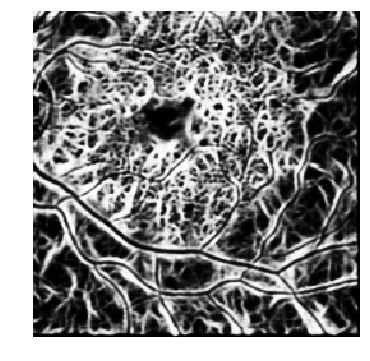

In [277]:
plt.figure(figsize=(6, 6))
plt.imshow(np.array(visualize(group_images(pred_imgs,N_visual),"all_predictions")),cmap='gray')
plt.axis('off')
plt.show()

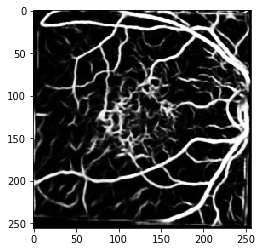

In [66]:
plt.imshow(np.array(visualize(group_images(pred_imgs,N_visual),"all_predictions")),cmap='gray')
plt.show()

In [29]:
np.max(np.array(visualize(group_images(pred_imgs,N_visual),"all_predictions")))

254

In [30]:
np.array(visualize(group_images(pred_imgs,N_visual),"all_predictions")).shape

(256, 256)

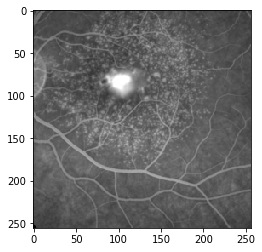

In [31]:
import matplotlib.pyplot as plt
plt.imshow(gen_imgs[0])
plt.show()

In [118]:
from skimage.io import imsave
imsave('infrared_1.jpg',gen_imgs[0])

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [119]:
imsave('cf_1.jpg',p1[0])

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [122]:
imsave('vessel_1.jpg',np.array(visualize(group_images(pred_imgs,N_visual),"all_predictions")))